# PreProcess and sanity checks

Import lib

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

Safety check

In [2]:
DATA = "data"
if not os.path.exists(DATA):
    raise FileNotFoundError(f"Expected data folder at {DATA}, but it was not found.")

load the csvs

In [3]:
vitals = pd.read_csv(f"{DATA}/sample_vital.csv", parse_dates=["timestamp"])
wear   = pd.read_csv(f"{DATA}/sample_wearable.csv", parse_dates=["timestamp"])
emo    = pd.read_csv(f"{DATA}/sample_emotion.csv", parse_dates=["timestamp"])


print the columns

In [4]:
print("vitals cols:", list(vitals.columns))
print("wear cols:", list(wear.columns))
print("emo cols:", list(emo.columns))
print("rows:", len(vitals), len(wear), len(emo))

vitals cols: ['patient_id', 'timestamp', 'heart_rate', 'spo2', 'resp_rate', 'temp', 'systolic_bp', 'diastolic_bp', 'device', 'quality_flag']
wear cols: ['patient_id', 'timestamp', 'step_count', 'activity_level', 'accel_x', 'accel_y', 'accel_z', 'calories', 'device', 'quality_flag']
emo cols: ['patient_id', 'timestamp', 'source', 'emotion', 'confidence', 'notes', 'model', 'privacy_tag']
rows: 20 20 10


Filter to enforece data quality based on schema.

In [5]:
vitals = vitals.query(
    "30 <= heart_rate <= 220 and 70 <= spo2 <= 100 and 4 <= resp_rate <= 60 and 30 <= temp <= 43"
)
wear = wear.query(
    "0 <= step_count <= 50000 and 0 <= calories <= 10000 and activity_level in ['sedentary','light','moderate','intense']"
)
emo = emo.query(
    "0.0 <= confidence <= 1.0 and source in ['face','voice','self_report'] and privacy_tag in ['normal','sensitive','restricted']"
)



scales the varaibles to a 1 to 0 range which would make it simpler to compare signals on a chart. For example steps vs bpm would be on complete different scales

In [6]:
vitals["hr_norm"]   = (vitals["heart_rate"] - 30) / (220 - 30)
vitals["spo2_norm"] = (vitals["spo2"] - 70) / (100 - 70)
wear["steps_norm"]  = wear["step_count"] / 50000
wear["cal_norm"]    = wear["calories"] / 10000



aligns wearable data and vitals by patient and timestamp to make sure only rows where both srouces exist

In [7]:
merged = pd.merge(
    vitals, wear,
    on=["patient_id", "timestamp"],
    how="inner",
    suffixes=("_v", "_w")
)

In [8]:
os.makedirs("cleaned", exist_ok=True)
vitals.to_csv("cleaned/vitals_clean.csv", index=False)
wear.to_csv("cleaned/wearables_clean.csv", index=False)
emo.to_csv("cleaned/emotions_clean.csv", index=False)
merged.to_csv("cleaned/merged_timeseries.csv", index=False)
print("written and cleaned/")

written and cleaned/


Here we create a plot for a easy visual analysis to see wheter the cleaned vital data looks normal

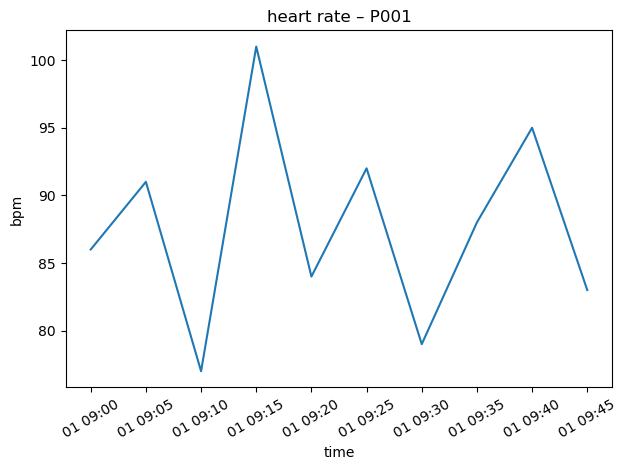

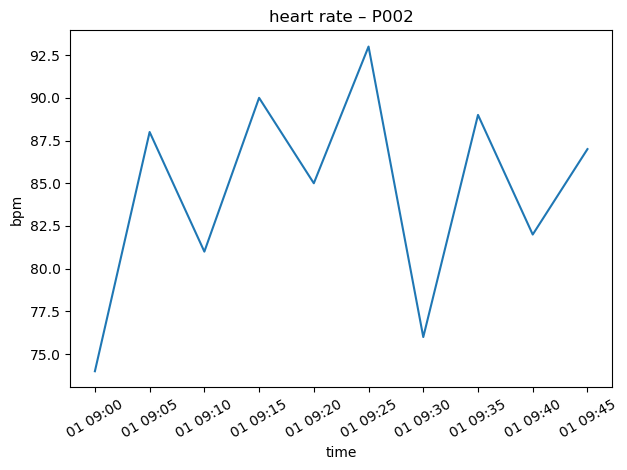

In [9]:
for pid, chunk in vitals.groupby("patient_id"):
    plt.figure()
    plt.plot(chunk["timestamp"], chunk["heart_rate"])
    plt.title(f"heart rate – {pid}")
    plt.xlabel("time"); plt.ylabel("bpm"); plt.xticks(rotation=30)
    plt.tight_layout(); plt.show()